In [1]:
%matplotlib inline
%autosave 60

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import scipy.optimize

from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic

Autosaving every 60 seconds


In [31]:
def gaussian_blur_image(arcImg, configDict):
    gaussianBlurSigma = configDict['gaussianBlurSigma']
    arcImgCp = gaussian_filter(arcImg, sigma=gaussianBlurSigma)
    
    return arcImgCp

def make_threshold_image(arcImg, configDict):
    threshold = configDict['threshold']
    arcImgCp = gaussian_blur_image(arcImg, configDict)
    brightPxs = np.zeros(arcImg.shape)
    brightPxs[arcImgCp > threshold] = 1
    
    return brightPxs

def convert_fov_degs_px(whDeg, plateScale):
    wDeg, hDeg = whDeg
    nXPx = wDeg * 3600 / plateScale
    nYPx = hDeg * 3600 / plateScale
    whPx = (int(nXPx), int(nYPx))
    
    return whPx

def xy_image_coord_transform(r, img, inverse=False):
    # Works with arrays of shape (2,) and (2, N)
    height, width = img.shape
    
    if inverse:
        rPrime0 = r[1]
        rPrime1 = height - r[0]
    else:
        rPrime0 = height - r[1]
        rPrime1 = r[0]

    rPrime = np.array([rPrime0, rPrime1]).reshape(r.shape)
    
    return rPrime

def score_center(center, img, dr):
    # Center in image coords (row, col)
    height, width = img.shape
    maxR = np.linalg.norm(np.array([height, width]))
    rBins = np.arange(0, int(maxR + 1), dr)
    
    # Calculate bright px distances from given center
    center = center.reshape((2, 1))
    rowBright, colBright = np.where(img > 0)
    brightIdx = np.vstack([rowBright, colBright])
    rBright = brightIdx - center
    rBright = np.linalg.norm(rBright, axis=0)
    
    # Calculate score
    nBrightInBin, binEdges = np.histogram(rBright, bins=rBins)
    brightRadii = binEdges[1:][nBrightInBin > 0]
        
    score = len(brightRadii)
    
    return score
    
def make_arc_image(configDict, thetaInit=0, driftTime=0):
    thetaInit *= np.pi / 180
    expTime = configDict['expTime']
    slewRate = configDict['slewRate']
    width = configDict['imageWidth']
    height = configDict['imageHeight']
    driftVel = configDict['driftVel']
    rng = configDict['rng']
    xMu = configDict['xMu']
    yMu = configDict['yMu']
    pointingSigma = configDict['pointingSigma']
    nStars = configDict['nStars'] 
    rotM_init = np.array([[np.cos(thetaInit), -np.sin(thetaInit)], [np.sin(thetaInit), np.cos(thetaInit)]])

    fCircle = expTime * slewRate / 360
    phiDot = slewRate * np.pi / 180
    
    vals = rng.standard_normal(2) # Sample gaussian twice

    # Define pointing center
    pointingCenter = np.array([xMu + pointingSigma * vals[0], yMu + pointingSigma * vals[1]]) # x and y
    
    # Add pointingCenter to configDict
    configDict['pointingCenter'] = pointingCenter

    tSteps = int(20000 * fCircle * 4)
    dt = expTime / tSteps
    times = np.arange(0, expTime + dt, dt)

    # Make an array for later use
    arcImg = np.zeros((height, width))

    for i in range(nStars): # Pretty sure this entire operation can be vectorized (tensorized)
        xExt0 = width * rng.random()
        yExt0 = height * rng.random()
        rExt0 = np.array([xExt0, yExt0])
        integratedDrift_t = (times + driftTime) * driftVel
        rExt_t = rExt0.reshape((2, 1)) + integratedDrift_t
        rotM_t = np.array([[[np.cos(phiDot * t), -np.sin(phiDot * t)], 
                            [np.sin(phiDot * t), np.cos(phiDot * t)]] for t in times])
        
        rPrime_t = rExt_t - pointingCenter.reshape((2, 1))
        rPrime_t = rPrime_t.transpose().reshape((rotM_t.shape[0], 2, 1))
        rCam_t = np.matmul(rotM_init, np.matmul(rotM_t, rPrime_t))
        rCam_t = rCam_t.transpose(0, 2, 1).squeeze()
        rCam_t = np.round(rCam_t)
        
        dataType = np.dtype([('x', rCam_t.dtype), ('y', rCam_t.dtype)])
        dataVectors = rCam_t.view(dtype=dataType).squeeze()
        uniqueVectors = np.array(np.unique(dataVectors).tolist())
        
        for rPrime in uniqueVectors:            
            r = pointingCenter + rPrime
            imgIdx = xy_image_coord_transform(r, arcImg)
            row = int(imgIdx[0])
            col = int(imgIdx[1])

            # Some arcs will go out of the image
            if row >= 0 and col >= 0:   
                try:
                    arcImg[(row, col)] += 1
                except IndexError:
                    pass
                
    return arcImg

def find_boresight(im0, im1, nTrials=10, dr=1):
    optimizerResults = np.zeros((2, nTrials, 2))
    
    for i, im in enumerate([im0, im1]):
        height, width = im.shape
        arguments = (im, dr)
    
        for iTrial in range(nTrials):
            optimizerResult = scipy.optimize.differential_evolution(score_center, ((0, height), (0, width)), 
                                                                    args=arguments)
            optimizerResults[i, iTrial] = optimizerResult.x
    foo = (optimizerResults[0] + optimizerResults[1]) / 2
    mu = foo.mean(axis=0)
    sigma = foo.std(axis=0)
    result = {'result': mu, 'sigma': sigma}
    
    return result

In [26]:
# Instrument Specs
focalLengths = [135, 375, 750]
whDegs = [(7.91, 5.93), (2.85, 2.13), (1.42, 1.07)] # Image width and height in Degrees
plateScales = [8.64, 3.11, 1.56] # plate scales of cameras in arcsec / px
whPxs = [convert_fov_degs_px(whDeg, plateScale) for whDeg, plateScale in zip(whDegs, plateScales)] 

# Notebook Configurables
camNum = 0 # Choose an instrument
slewRate = 6 # degs / s
driftDir = np.array([[1],[0]]) # Drifting right in px space initially
driftSpeedArcSec = 13 # arcseconds / s
threshold = 0.3 # Bright pixel Threshold
gaussianBlurSigma = 1 # PSF width
pointingSigma = 300 # STD of pointings around image center
expTime = 15 # seconds
seed = 1000 # 98735927 # Set a seed (optional)
figsDir = os.path.expanduser('~/Pictures/work/lsst/startracker/simulate_drift') # Where to save the figures
saveFig = True
dr = 1 # Radial bin width for Scoring Center
nStars = 35
thetaInits = [0, 180]
driftTimes = [0, 180]

# Parameters Derived / Selected from Configurables
driftSpeedDeg = driftSpeedArcSec / 3600 # deg / s 
focalLength = focalLengths[camNum]
plateScale = plateScales[camNum]
width, height = whPxs[camNum]
driftVel = driftSpeedArcSec / (plateScale) * driftDir # Drift in px / s
xMu = width / 2 
yMu = height / 2

In [32]:
nTrials = 10
errors = np.zeros((nTrials, 2, 2))
ims = []

for i, (thetaInit, driftTime) in enumerate(zip(thetaInits, driftTimes)):
    # numpy random Stuff
    if seed is None:
        rng = np.random.default_rng() # Make one of these things
    else:
        rng = np.random.default_rng(seed)

    # Dictionary of Configurables to pass to functions
    configDict = {
        'expTime': expTime,
        'slewRate': slewRate,
        'driftVel': driftVel,
        'threshold': threshold,
        'rng': rng,
        'imageWidth': width,
        'imageHeight': height,
        'gaussianBlurSigma': gaussianBlurSigma,
        'xMu': xMu,
        'yMu': yMu,
        'pointingSigma': pointingSigma,
        'nStars': nStars
        }
    
    arcImg = make_arc_image(configDict, thetaInit=thetaInit, driftTime=driftTime)
    pointingCenter = configDict['pointingCenter']
    pcIdx = xy_image_coord_transform(pointingCenter, arcImg)
    brightPxs = make_threshold_image(arcImg, configDict)
    ims.append(brightPxs)
    arguments = (brightPxs, dr)
    
    for iTrial in range(nTrials):
        result = scipy.optimize.differential_evolution(score_center, ((0, height), (0, width)), 
                                                      args=arguments)
        optimizerError = pcIdx - result.x
        errors[iTrial, i] = optimizerError

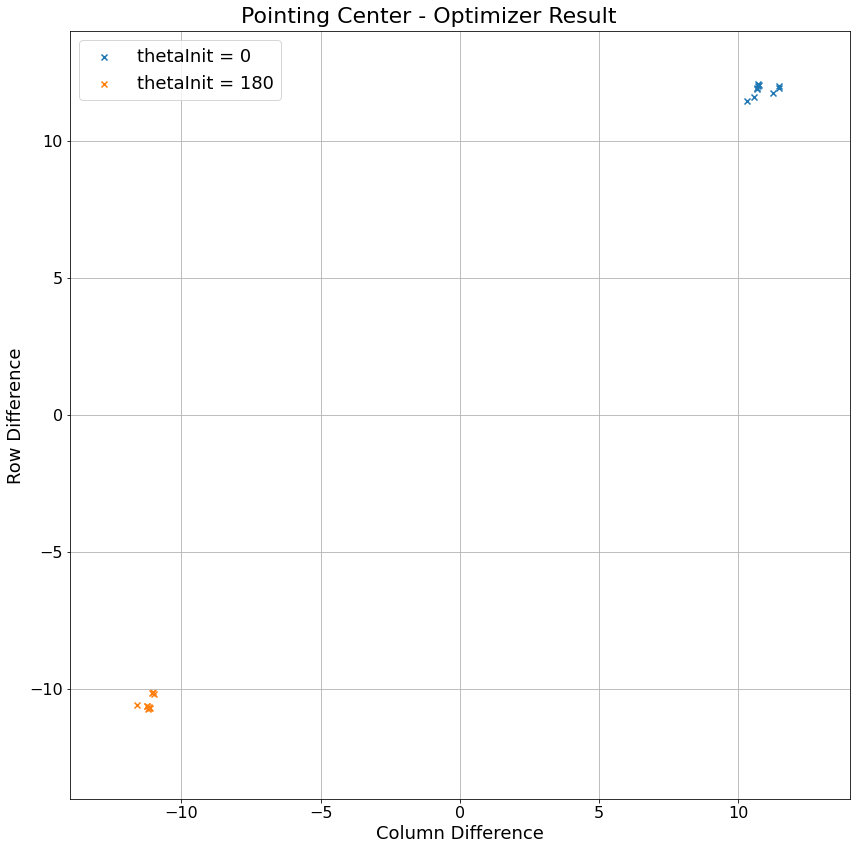

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))
fig.suptitle('Pointing Center - Optimizer Result', fontsize=22)
ax.set_ylabel('Row Difference', fontsize=18)
ax.set_xlabel('Column Difference', fontsize=18)
ax.set_xlim(-14, 14)
ax.set_ylim(-14, 14)
ax.tick_params(labelsize=16)
ax.grid(visible=True)

for iTheta, thetaInit in enumerate(thetaInits):
    data = errors[:, iTheta].transpose()
    x = data[1]
    y = data[0]
    ax.scatter(x, y, marker='x', label=f'thetaInit = {thetaInit}')
    
ax.legend(fontsize=18)
fig.tight_layout()
fName = 'optimizer_errors.png'
fileName = os.path.join(figsDir, fName)
fig.savefig(fileName)
plt.show(fig)

In [33]:
boresight = find_boresight(ims[0], ims[1])

{'result': array([1380.04798907, 1551.28443536]), 'sigma': array([0.11506142, 0.19133959])}


In [37]:
pcIdx = xy_image_coord_transform(configDict['pointingCenter'], ims[0])
print(boresight, pcIdx)
print(boresight['result']-pcIdx)

{'result': array([1380.04798907, 1551.28443536]), 'sigma': array([0.11506142, 0.19133959])} [1380.69844348 1551.1009382 ]
[-0.65045441  0.18349716]
